## A - Building inference networks with SwyftModule

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: We go through the basic steps of performing parameter inference with Swyft.

**Note**: As is always the case when dealing with training of artificial neural networks, obtaining optimal results depends on a proper setting of training and network parameters.  This will be discussed later.

**Key take-away messages**: Understand swyft's main functions for data and dataloaders (`swyft.Samples`, `swyft.SwyftDataModule`), networks (`swyft.SwyftModule`) and training/inference (`swyft.SwyftTrainer`).

### Code

#### Setup

First we need some imports.

In [1]:
import numpy as np
import pylab as plt
import torch

import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
np.random.seed(0)

#### Training data

Now we generate training data.  As a simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{U}(-1, 1)$ is drawn from the uniform distribution, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is small additive noise.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

Let us generate some samples first, here by using basic numpy functionality.

In [3]:
N = 10_000  # Number of samples
z = np.random.rand(N, 1)*2-1  # Uniform prior over [-1, 1]
x = z + np.random.randn(N, 1)*0.2 # N by 1 array, normal w/ variance of 0.2

Note that the shape of the `z` and `x` arrays is (n_samples, 1). The first dimension corresponds to the number of samples. Subsequent dimensions correspond to data and parameter shapes (here simply one in both cases).

It is instructive to visualize the training data. 
- Blue dots: generated $(x, z)$ pairs ("jointly sampled")
- Red dots: scrambled $(x, z)$ pairs ("marginally sampled").

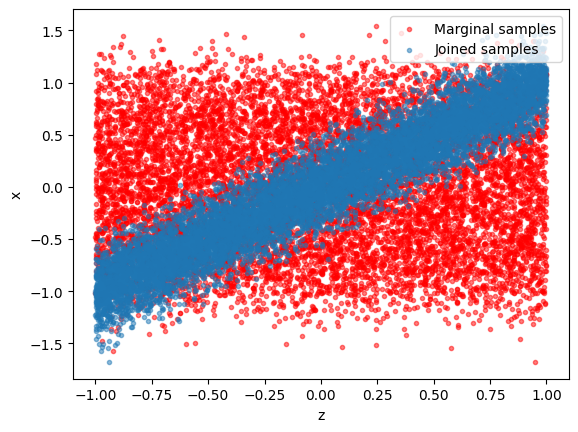

In [4]:
plt.scatter(z[:,0], np.random.permutation(x[:,0]), alpha = 0.5, marker='.', color='r', label = "Marginal samples"); plt.xlabel("z"); plt.ylabel("x");
plt.scatter(z[:,0], x[:,0], alpha = 0.5, marker='.', label = "Joined samples"); plt.xlabel("z"); plt.ylabel("x"); plt.legend(loc = 1)

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [5]:
samples = swyft.Samples(x = x, z = z)

#### Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(a; b) = \frac{p(a, b)}{p(a)p(b)}\;,
$$
where $a$ and $b$ refer to any components of the training data.  In the below example, we set $a \to x$ and $b \to z$.

In [6]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z', num_blocks = 4) #Posterior for z?

    def forward(self, A, B):
        return self.logratios(A['x'], B['z'])

Swyft comes with a few default networks. Here we use `swyft.LogRatioEstimator_1dim`, which is a dense network that estimates (potentially multiple) one-dimensional posteriors. In the present example, the length of the parameter vector (`num_params`) and data vectors (`num_features`) are one.

#### Training

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).  Since our training data is double precision in this example, we have to set `precision = 64`.

In [7]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cac

The `swyft.SwyftDataModule` class provides convenience functions to generate data loaders for training and validation data. We preserve 20% of samples for validation.

In [8]:
dm = swyft.SwyftDataModule(samples, batch_size=128)

Finally we instantiate our inference network...

In [9]:
network = Network()
trainer.fit(network, dm)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.6 K
-----------------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.276     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 37.95it/s, loss=-0.587, v_num=1, val_loss=-.600]
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_1/checkpoints/epoch=2-step=189.ckpt


...and start training.

#### Inference

Let's assume that we measured the values $x=0.0$. We put this observation in a `swyft.Sample` object (representing a single sample).

In [10]:
x0 = 0.0
obs = swyft.Sample(x = np.array([x0]))

Since the inference network estimates the (logarithm of the) posterior-to-prior ratio, we can obtain weighted posterior samples by running many prior samples through the inference network. To this end, we first generate prior samples.

In [27]:
prior_samples = swyft.Samples(z = np.random.rand(5000, 1)*2-1)

Then we evaluate the inference network by using the `infer` method of the `swyft.Trainer` object.

In [28]:
predictions = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 59.99it/s]


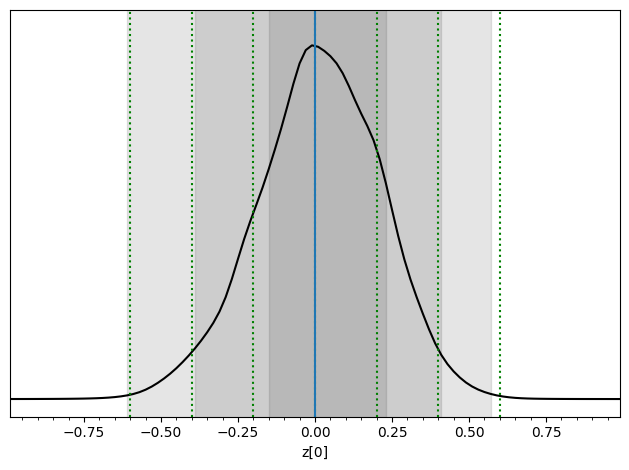

In [29]:
swyft.plot_posterior(predictions, 'z[0]', smooth = 2)
for offset in [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
    plt.axvline(x0+offset, color='g', ls = ':')
plt.axvline(x0)

Voilà. You performed a basic parameter inference task with neural ratio estimation. The gray regions should the 68.3%, 95.5% and 99.7% highest density credible regions.  The correct regions are indicated by the green vertical lines. The result will not be perfect, but we will discuss later possible ways to improve.

### Exercises

1. The `swyft.Samples` object is compatible with array slicing operatios ([details](https://www.w3schools.com/python/numpy/numpy_array_slicing.asp)). Extract the first 3 samples from the `samples` object by using numpy array slicing notation.

In [18]:
# Your results goes here
samples[0:3]

Samples({'x': array([[-0.04753706],
       [ 0.54307384],
       [ 0.11840033]]), 'z': array([[0.09762701],
       [0.43037873],
       [0.20552675]])})


2. The return type of `swyft.LogRatioEstimator_1dim`, and in the above example of the inference network, is `swyft.LogRatioSamples`. 
- Confirm that this is also the type of the `predictions` returned by the `infer` method.
- Extract $\ln r(x; z)$ (contained in the `logratios` variable) as well as the parameter $z$ (contained in the `params` variable) from the `predictions`.
- Plot $\ln r(x;z)$ vs $z$ using `plt.scatter` (make sure to pass everything as vectors).

Text(0.5, 1.0, 'Log Ratio for Observation x=0')

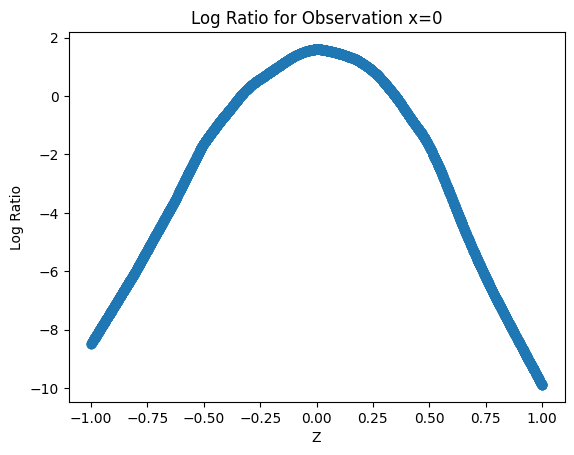

In [37]:
# Your results goes here
type(predictions)

log_ratio = predictions.logratios
param_z = predictions.params

plt.scatter(param_z, log_ratio)
plt.xlabel("Z")
plt.ylabel("Log Ratio")
plt.title("Log Ratio for Observation x=0")

#Note that chart has a peak at value for z = 0

In [30]:

print(len(predictions.logratios))

5000


5000